In [48]:
# ruff: noqa: T201

# ruff: noqa: T201, D105, D101

# Force auto reload of modules
%reload_ext autoreload
%autoreload 2

# Imports
import datetime
import re
from collections.abc import Sequence
from dataclasses import dataclass, field
from enum import Enum
from itertools import combinations, permutations
from pathlib import Path
from typing import Any, ClassVar, Literal

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator

# ------------------------------------------------------------
# Define experiment constants here
# ------------------------------------------------------------


CONTACT_Y_COORDINATE = -0.05650916132908832

BAG_FILE_OUTPUT_FOLDER = Path("/home/jelle/thesis/nakama_ws/src/touch-detection/output")

CLOCK_SYNC_BASE_PATH: Path = Path("/home/jelle/thesis/nakama_ws/src/clock_synchronization/output/")

CLOCK_NAME = "ros_clock_now"

ZERO_OFFSET = datetime.timedelta()

# ------------------------------------------------------------
# End of configuration
# ------------------------------------------------------------


# Initialize constants & data structures


class ClockSyncType(Enum):
    CHRONY_LOCAL = "chrony local"
    TIMESYNCD = "timesyncd"

    def __str__(self) -> Literal["chrony local", "timesyncd"]:
        return self.value


def load_bag_paths() -> list[Path]:
    """Get all full experiment names based the bagfile recordings directory."""
    return list(BAG_FILE_OUTPUT_FOLDER.glob("td_exp_*_rep_*"))


def load_full_names() -> list[str]:
    """Get all full experiment names based the bagfile recordings directory."""
    return [path.name for path in load_bag_paths()]


def get_exp_nr(full_name: str) -> int:
    """Get experiment number."""
    exp_nr_match = re.search(r"exp_(\d+)", full_name)
    if exp_nr_match:
        return int(exp_nr_match.group(1))

    msg = f"Cannot determine experiment number for {full_name}"
    raise ValueError(msg)


def get_sync_type(full_name: str) -> ClockSyncType:
    """Get the clock sync type (timesyncd or chrony local)."""
    if "chrony_local" in full_name:
        return ClockSyncType.CHRONY_LOCAL
    if "timesyncd" in full_name:
        return ClockSyncType.TIMESYNCD

    msg = f"Cannot determine synchronization type for {full_name}"
    raise ValueError(msg)


def get_offset(full_name: str) -> datetime.timedelta:
    """Get the deliberate clock sync offset."""
    offset_match = re.search(r"offset_(\d+(?:\.\d+)?)(ms|s)", full_name)
    if offset_match:
        value, unit = offset_match.groups()
        if unit == "s":
            return datetime.timedelta(seconds=float(value))
        if unit == "ms":
            return datetime.timedelta(milliseconds=float(value))

        msg = f"Cannot determine offset unit for {full_name}"
        raise ValueError(msg)

    # No offset match found, return no offset (zero timedelta)
    return datetime.timedelta()


def get_rep(full_name: str) -> int:
    """Get the repetition number."""
    rep_match = re.search(r"_rep_(\d+)", full_name)
    if rep_match:
        return int(rep_match.group(1))

    msg = f"Cannot determine repetition number for {full_name}"
    raise ValueError(msg)


def short_timedelta_repr(timedelta: datetime.timedelta) -> str:
    """Get a short timedelta representation for in a table."""
    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return "-"

    if timedelta.seconds != 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return f"{timedelta.seconds * 1000} ms"

    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds != 0:
        if timedelta.microseconds % 1000 == 0:
            # Can represent as milliseconds, do that
            return f"{timedelta.microseconds / 1000} ms"
        # Cannot represent as milliseconds
        return f"{timedelta.microseconds} us"

    # If none of the other options are available, just use the regular formatting
    return str(timedelta)


def timedelta_repr(timedelta: datetime.timedelta) -> str:
    """Get a timedelta representation for in a table."""
    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return "no offset"

    if timedelta.seconds != 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return f"{timedelta.seconds * 1000} ms"

    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds != 0:
        if timedelta.microseconds % 1000 == 0:
            # Can represent as milliseconds, do that
            return f"{timedelta.microseconds / 1000} ms"
        # Cannot represent as milliseconds
        return f"{timedelta.microseconds} us"

    # If none of the other options are available, just use the regular formatting
    return str(timedelta)


def clock_sync_folder(full_name: str) -> str:
    """Get the clock sync folder for a specific repetition."""
    return str(CLOCK_SYNC_BASE_PATH / f"{full_name}")


@dataclass
class ExperimentRowSelectionBase:
    rep_nrs: int | list[int] | Literal["ALL"]


@dataclass
class ExperimentRowSelectionCriteria(ExperimentRowSelectionBase):
    sync_type: ClockSyncType
    offset: datetime.timedelta


@dataclass
class ExperimentRowSelectionNr(ExperimentRowSelectionBase):
    exp_nr: int | list[int] | Literal["ALL"]


def select_experiment_rows(
    exp_df: pd.DataFrame,
    selection_criteria: Sequence[ExperimentRowSelectionCriteria | ExperimentRowSelectionNr],
) -> pd.DataFrame:
    """Select experiment rows as alternative to groupby API from pandas."""
    selected_rows: list[pd.DataFrame] = []

    for criterion in selection_criteria:
        # Select all rep numbers if specified
        if criterion.rep_nrs == "ALL":
            # Select data based on all inputs except rep numbers (i.e. select all rep numbers)
            if isinstance(criterion, ExperimentRowSelectionCriteria):
                selected_rows.append(
                    exp_df[(exp_df["sync_type"] == str(criterion.sync_type)) & (exp_df["offset"] == criterion.offset)]
                )
            elif isinstance(criterion, ExperimentRowSelectionNr):
                if criterion.exp_nr == "ALL":
                    selected_rows.append(exp_df.copy())
                else:
                    selected_rows.append(exp_df[exp_df["exp_nr"] == criterion.exp_nr])

        else:
            # If one rep number is given, convert it to a list with one element
            rep_nrs = [criterion.rep_nrs] if isinstance(criterion.rep_nrs, int) else criterion.rep_nrs

            # Select data based on all inputs and rep numbers
            if isinstance(criterion, ExperimentRowSelectionCriteria):
                selected_rows.append(
                    exp_df[
                        (exp_df["sync_type"] == str(criterion.sync_type))
                        & (exp_df["offset"] == criterion.offset)
                        & (exp_df["rep"].isin(rep_nrs))
                    ]
                )
            elif isinstance(criterion, ExperimentRowSelectionNr):
                selected_rows.append(exp_df[(exp_df["exp_nr"] == criterion.exp_nr) & (exp_df["rep"].isin(rep_nrs))])

    return pd.concat(selected_rows, ignore_index=True)


# def is_part_of_criteria(partial_df: pd.DataFrame, selection_criteria: list[ExperimentRowSelectionCriteria]) -> bool:
#     """Check if a partial DF would be included in criteria."""
#     for criterion in selection_criteria:
#         # Select all rep numbers if specified
#         if criterion.rep_nrs == "ALL":
#             # Select data based on all inputs except rep numbers (i.e. select all rep numbers)
#             if (
#                 (partial_df["hec_type"] == str(criterion.hec_type))
#                 & (partial_df["sync_type"] == str(criterion.sync_type))
#                 & (partial_df["sample_rate"] == criterion.sample_rate)
#                 & (partial_df["offset"] == criterion.offset)
#             ).any():
#                 return True

#         else:
#             # If one rep number is given, convert it to a list with one element
#             rep_nrs = [criterion.rep_nrs] if isinstance(criterion.rep_nrs, int) else criterion.rep_nrs

#             # Select data based on all inputs and rep numbers
#             if (
#                 (partial_df["hec_type"] == str(criterion.hec_type))
#                 & (partial_df["sync_type"] == str(criterion.sync_type))
#                 & (partial_df["sample_rate"] == criterion.sample_rate)
#                 & (partial_df["offset"] == criterion.offset)
#                 & (partial_df["rep"].isin(rep_nrs))
#             ).any():
#                 return True

#     # None of the criteria was found
#     return False


def extract_timestamp(filepath: Path) -> datetime.datetime | None:
    """Helper function to obtain timestamp from filename."""
    try:
        filename = filepath.name
        timestamp_str = filename.split("_")[0]
        return datetime.datetime.fromisoformat(timestamp_str).astimezone()
    except (IndexError, ValueError) as e:
        print(f"Skipping file {filepath}: can't parse timestamp. ({e})")
        return None


In [49]:
full_experiment_names = load_full_names()
bag_paths = load_bag_paths()

# Convert to DataFrame
overview_df = pd.DataFrame(
    {
        "full_name": load_full_names(),
        "exp_nr": [get_exp_nr(full_name) for full_name in full_experiment_names],
        "rep": [get_rep(full_name) for full_name in full_experiment_names],
        "sync_type": [str(get_sync_type(full_name)) for full_name in full_experiment_names],
        "offset": [get_offset(full_name) for full_name in full_experiment_names],
        "bag_path": bag_paths,
        "robot_data_csv_path": [path / "robot.csv" for path in bag_paths],
        "force_data_csv_path": [path / "force.csv" for path in bag_paths],
        "clock_sync_folder": [clock_sync_folder(full_name) for full_name in full_experiment_names],
    },
)
# Sort values based on experiment names and repetitions, and create new index column
overview_df = overview_df.sort_values(by=["exp_nr", "rep"], ignore_index=True)

In [50]:
def get_clock_offset_values(experiment_row: pd.Series) -> pd.Series:
    """Vectorisation function to get all clock offsets for a specific experiment."""
    # Obtain csv files based on timestamps
    summary_csv_files = list(Path(experiment_row["clock_sync_folder"]).glob("**/*.summary.csv"))

    # Ensure that the files are processed in order of when they were created (because timestamp is included in the name)
    summary_csv_files.sort()

    # Process summary CSV files
    from_to_dict: dict[tuple[str, str], list[dict[str, Any]]] = {}
    for filepath in summary_csv_files:
        # Read CSV file and transpose to obtain hosts as index column
        summary_df = pd.read_csv(filepath, index_col=0).transpose()

        # Obtain clock names and hostnames
        clock_names = [col.split()[0] for col in summary_df.columns if col.endswith("offset mean")]
        clock_names = [clock_names[0]] if clock_names else []  # TODO: Remove selection of first clock
        hostnames = summary_df.index.tolist()

        from_to_host_combinations: list[tuple[str, str]] = list(combinations(hostnames, 2))

        # Combine only unique from/to hostname combinations
        for from_host, to_host in from_to_host_combinations:
            # Add this combination of hosts to the dictionary if it doesn't exist yet
            if (from_host, to_host) not in from_to_dict:
                from_to_dict[(from_host, to_host)] = []

            # Add metadata
            from_to_dict_entry = {
                "processing_time": summary_df.loc[f"{from_host}", "processing_time"],
                "source_node_name": summary_df.loc[f"{from_host}", "source_node_name"],
                "N msgs": summary_df.loc[f"{from_host}", "N msgs"],
            }

            # Add relevant clock metrics
            for clock_name in clock_names:
                from_to_dict_entry.update(
                    {
                        f"{clock_name} diff mean": summary_df.loc[f"{from_host}", f"{clock_name} diff mean"],
                        f"{clock_name} diff std": summary_df.loc[f"{from_host}", f"{clock_name} diff std"],
                        f"{clock_name} offset mean": summary_df.loc[f"{from_host}", f"{clock_name} offset mean"],
                        f"{clock_name} offset std": summary_df.loc[f"{from_host}", f"{clock_name} offset std"],
                        f"{clock_name} round trip delay mean": summary_df.loc[
                            f"{from_host}", f"{clock_name} round trip delay mean"
                        ],
                        f"{clock_name} round trip delay std": summary_df.loc[
                            f"{from_host}", f"{clock_name} round trip delay std"
                        ],
                    }
                )

            # Add this entry to the list of entries
            from_to_dict[(from_host, to_host)].append(from_to_dict_entry)

    # # Flatten the dictionary into a list of records with index tuples
    # records = [{"from": k[0], "to": k[1], **entry} for k, v in from_to_dict.items() for entry in v]

    # # Create DataFrame
    # from_to_df = pd.DataFrame(records)

    # # Set MultiIndex
    # from_to_df = from_to_df.set_index(["from", "to"])

    # # Get the processing time of the first summary file
    # earliest_time: Timestamp = min(pd.to_datetime(from_to_df["processing_time"]))  # type: ignore  # noqa: PGH003

    # # Get relative experiment time (number of seconds from the start of the experiment)
    # from_to_df["experiment_time"] = pd.to_datetime(from_to_df["processing_time"]) - earliest_time

    return pd.Series(
        {
            "clock_sync_from_to_dict": from_to_dict,
        }
    )


# Compute the calibration error for each row and add as new columns (not the most readable way to do this but it works)
overview_df[
    [
        "clock_sync_from_to_dict",
    ]
] = overview_df.apply(
    get_clock_offset_values,
    axis="columns",  # Setting this to "columns" applies the function to each row (I know right?)
)

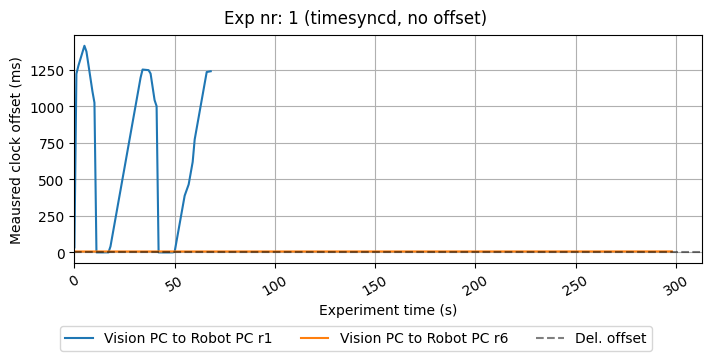

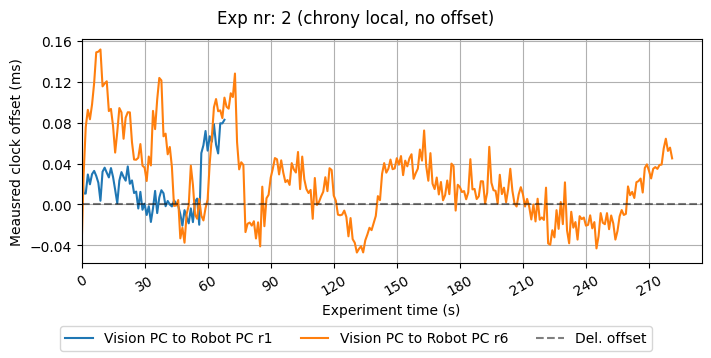

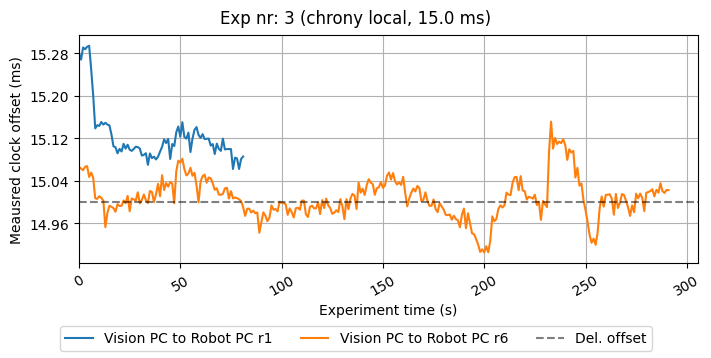

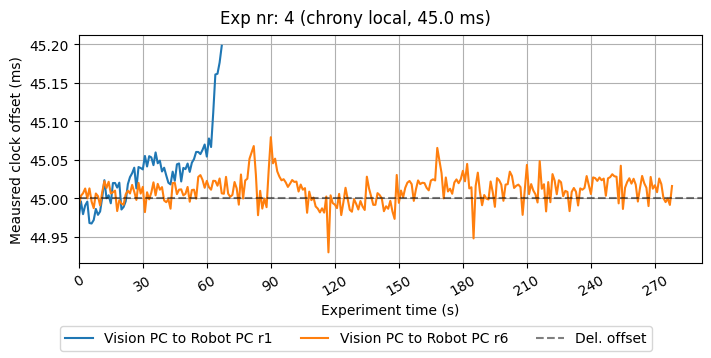

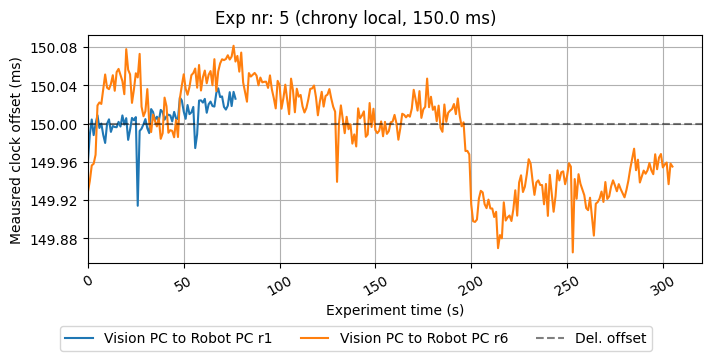

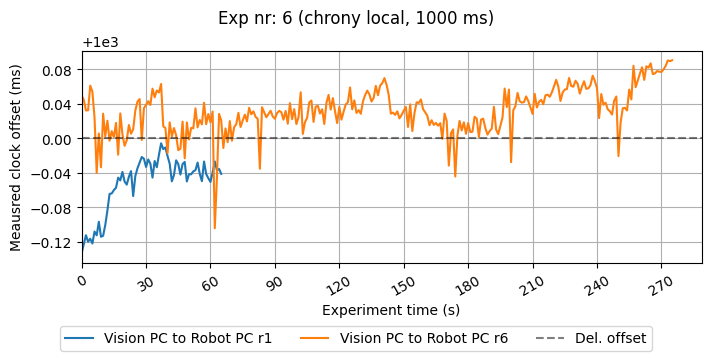

In [54]:
from matplotlib.axes import Axes


@dataclass
class ClockSyncConfig:
    name: str

    # How much time at the start of the experiment to exclude from the plot
    plot_time_exclude_start: datetime.timedelta = field(default_factory=datetime.timedelta)

    # Host name to server/client name mapping
    host_mapping: dict[str, str] = field(
        default_factory=lambda: {
            "nakama6000-desktop": "AI PC",
            "nakama-X570-AORUS-PRO": "Vision PC",
            "nakama-cubi": "Robot PC",
            "jelle-ubuntu-22": "Force PC",
        }
    )

    exclude_hosts: list[str] = field(default_factory=list)

    # Which host is the local server and whether to show that in the plot (only suitable for local network experiment)
    local_server_host: str = "nakama-X570-AORUS-PRO"
    show_local_server_in_plot: bool = True

    # Where to save figures
    savefig_folder = Path("/home/jelle/thesis/nakama_ws/src/touch-detection/output/")


def short_timedelta_repr(timedelta: datetime.timedelta) -> str:
    """Get a short timedelta representation for in a table."""
    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return "-"

    if timedelta.seconds != 0 and timedelta.days == 0 and timedelta.microseconds == 0:
        return f"{timedelta.seconds * 1000} ms"

    if timedelta.seconds == 0 and timedelta.days == 0 and timedelta.microseconds != 0:
        if timedelta.microseconds % 1000 == 0:
            # Can represent as milliseconds, do that
            return f"{timedelta.microseconds / 1000} ms"
        # Cannot represent as milliseconds
        return f"{timedelta.microseconds} us"

    # If none of the other options are available, just use the regular formatting
    return str(timedelta)


CLOCK_SYNC_CONFIG = ClockSyncConfig(
    name="chrony default",
    # exclude_hosts=["nakama6000-desktop"],
    exclude_hosts=["nakama-X570-AORUS-PRO"],
    local_server_host="nakama-X570-AORUS-PRO",
    host_mapping={
        "nakama6000-desktop": "Vision PC",
        "nakama-X570-AORUS-PRO": "AI PC",
        "nakama-cubi": "Robot PC",
        "jelle-ubuntu-22": "Vision PC",
    },
    show_local_server_in_plot=False,
)


def plot_offset(
    from_to_dict: dict[tuple[str, str], list[dict[str, Any]]],
    clock_sync_config: ClockSyncConfig,
    subplot_offset: Axes,
    rep_nr: int,
) -> None:
    from_to_items = list(from_to_dict.items())
    # from_to_items.sort(
    #     key=lambda tup: key_sort_from_to_hostnames(tup[0], clock_sync_config), reverse=True
    # )  # Sort by from hostname
    for (from_host, to_host), entries in from_to_items:
        # Copy data to new dataframe and sort on the obtained data (x-axis)
        from_to_df = pd.DataFrame(entries)
        from_to_df = from_to_df.sort_values(by="processing_time")

        # Get the processing time of the first summary file
        earliest_time = pd.to_datetime(from_to_df.loc[from_to_df.index[0], "processing_time"])  # type: ignore  # noqa: PGH003

        # Get relative experiment time (number of seconds from the start of the experiment)
        from_to_df["experiment_time"] = pd.to_datetime(from_to_df["processing_time"]) - earliest_time

        from_host_display_name = clock_sync_config.host_mapping.get(from_host, from_host)
        to_host_display_name = clock_sync_config.host_mapping.get(to_host, to_host)

        # # Ugly hack to fix some data inconsistencies in specific configuration
        # if is_part_of_criteria(
        #     partial_df,
        #     [ExperimentRowSelectionCriteria(hec_type=HecType.STATIC, sync_type=ClockSyncType.CHRONY_LOCAL, rep_nrs=3)],
        # ):
        #     # Skip plotting from Force PC to Robot PC, we already have the other way around
        #     if from_host_display_name == "Force PC":
        #         continue
        #     # Some weird data spikes occur after t=135, we don't want those in the plot
        #     from_to_df = from_to_df[from_to_df["experiment_time"].dt.total_seconds() < 135]  # noqa: PLR2004

        # # Ugly hack to fix some data inconsistencies in specific configuration
        # if is_part_of_criteria(
        #     partial_df,
        #     [ExperimentRowSelectionCriteria(hec_type=HecType.STATIC, sync_type=ClockSyncType.TIMESYNCD, rep_nrs=3)],
        # ):
        #     # Skip plotting from Force PC to Robot PC, we already have the other way around
        #     if from_host_display_name == "Force PC":
        #         continue
        #     # Some weird data spikes occur after t=119, we don't want those in the plot
        #     from_to_df = from_to_df[from_to_df["experiment_time"].dt.total_seconds() < 119]  # noqa: PLR2004

        # Possibly change the hostname to include the local server indicator
        if clock_sync_config.show_local_server_in_plot and from_host == clock_sync_config.local_server_host:
            from_host_display_name = f"{from_host_display_name} (local server)"
        if clock_sync_config.show_local_server_in_plot and to_host == clock_sync_config.local_server_host:
            to_host_display_name = f"{to_host_display_name} (local server)"

        # Obtain clock names
        clock_names = [col.split()[0] for col in from_to_df.columns if col.endswith("offset mean")]
        clock_names = [clock_names[0]] if clock_names else []  # Only select the first clock

        for clock in clock_names:
            ### Offset plotting

            # Convert offset values from ns to ms
            clock_offset_mean_ms = pd.to_numeric(from_to_df[f"{clock} offset mean"]) / 1e6

            # If most of the data is negative, invert the relation
            if clock_offset_mean_ms.mean() < 0:
                clock_offset_mean_ms = clock_offset_mean_ms * -1

            # If some time is excluded from the start of the plot, make sure that the time axis reflects that
            experiment_plot_time = from_to_df["experiment_time"] + clock_sync_config.plot_time_exclude_start

            # Plot offset values
            subplot_offset.plot(
                experiment_plot_time.dt.total_seconds(),
                clock_offset_mean_ms,
                label=f"{from_host_display_name} to {to_host_display_name} r{rep_nr}",
            )

            # Plot offset uncertainty
            # clock_offset_std_ms = pd.to_numeric(from_to_df[f"{clock} offset std"]) / 1e6
            # nr_stdev = 3  # Plot 3 st.dev = 99.7% accuracy range
            # subplot_offset.fill_between(
            #     experiment_plot_time.dt.total_seconds(),
            #     clock_offset_mean_ms - nr_stdev * clock_offset_std_ms,
            #     clock_offset_mean_ms + nr_stdev * clock_offset_std_ms,
            #     alpha=0.2,
            # )

            # Add axis labels
            subplot_offset.set_title("Meausred clock offset")
            subplot_offset.set_xlabel("Experiment time (s)")
            subplot_offset.set_ylabel("Meausred clock offset (ms)")


def plot_clock_offsets_td_experiment(td_exp_df: pd.DataFrame) -> None:
    fig, subplot_offset = plt.subplots(
        nrows=1,
        ncols=1,
        sharex=True,
        figsize=(7, 3.5),
        layout="constrained",
    )

    for rep_nr in td_exp_df["rep"].unique():
        rep_df = td_exp_df[td_exp_df["rep"] == rep_nr]
        plot_offset(
            from_to_dict=rep_df["clock_sync_from_to_dict"].iloc[0],
            clock_sync_config=CLOCK_SYNC_CONFIG,
            subplot_offset=subplot_offset,
            rep_nr=rep_nr,
        )

    # Apply formatting to all subplots
    for subplot in fig.axes:
        subplot.grid(True)

        # Format x-axis
        subplot.tick_params(axis="x", rotation=30)  # Rotate the x-axis ticks
        subplot.xaxis.set_tick_params(labelbottom=True)
        x_min, x_max = subplot.get_xlim()
        x_min = 0
        subplot.set_xlim(x_min, x_max)
        subplot.xaxis.set_major_locator(MaxNLocator(steps=[3, 5, 10]))  # Use multiples which make sense for minutes

        # Format y-axis
        y_min, y_max = subplot.get_ylim()
        # subplot.axhline(linewidth=1, color="k")  # Make line y=0 more visible
        # y_min = min(y_min, 0)  # Force include y=0
        # y_min = -1  # Use custom y limit
        # y_max = max(y_max, 0)  # Force include y=0
        # y_max = 1  # Use custom y limit
        subplot.set_ylim(y_min, y_max)
        subplot.yaxis.set_major_locator(MaxNLocator(nbins=7, prune=None))

        deliberate_offset = td_exp_df["offset"].iloc[0]
        deliberate_offset_ms = deliberate_offset.seconds * 1000 + deliberate_offset.microseconds / 1000
        subplot_offset.axhline(
            deliberate_offset_ms,
            label="Del. offset",
            linestyle="dashed",
            color="black",
            alpha=0.5,
        )

    # Place legend outside the plot
    handles, labels = fig.axes[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels, loc="outside lower center", ncol=len(handles))

    # Set the main title for the figure
    fig.axes[0].set_title("")  # Disable title for upper figure
    formatted_title = (
        f"Exp nr: {td_exp_df['exp_nr'].iloc[0]} "
        f"({td_exp_df['sync_type'].iloc[0]}, {timedelta_repr(td_exp_df['offset'].iloc[0])})"
    )

    fig.suptitle(f"{formatted_title}")

    savefig_experiment_name = td_exp_df["full_name"].iloc[0].replace(" ", "_")

    savefig_filename = f"clock_offset_td_exp_{savefig_experiment_name}.png"
    fig.savefig(CLOCK_SYNC_CONFIG.savefig_folder / savefig_filename)

    plt.show()

    legend.remove()
    savefig_nolegend_filename = f"clock_offset_td_exp_{savefig_experiment_name}_nolegend.png"
    fig.savefig(CLOCK_SYNC_CONFIG.savefig_folder / savefig_nolegend_filename)


selected_experiments_df = select_experiment_rows(
    exp_df=overview_df,
    selection_criteria=[
        ExperimentRowSelectionNr(
            exp_nr="ALL",
            rep_nrs="ALL",
        ),
    ],
)

for _, group in selected_experiments_df.groupby("exp_nr", group_keys=False):
    plot_clock_offsets_td_experiment(group)

# for row_index in range(len(hec_experiments_df)):
#     experiment_row = hec_experiments_df.iloc[[row_index]]
#     plot_clock_offsets_hec_experiment(experiment_row)